In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pathlib
import pandas as pd
import time
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
def return_names(root_dir,str1):
    data_root = pathlib.Path(root_dir)
    print("root is",data_root)
    all_pics_path=list(data_root.glob("**/*."+ str1))
    all_pics_path=[str(path) for path in all_pics_path]
    dict1={str1: all_pics_path}

    data_df=pd.DataFrame(dict1)
    return data_df




CHAR_VECTOR = "#0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMÉNOPQRSTUVWXYZ-~`´<>'.:;^/|!?$%@&*()[]{}_+=,\\\""
num_classes=len(CHAR_VECTOR)+1

from models import detector,r

from inf_fns import restore_rectangle,nms_locality,restore_roiRotatePara


Using TensorFlow backend.


In [2]:
rdir='C:\\Users\\Abhi\Desktop\\CS2\\icdar2015\\ch4_training_images'
icdar_2015=return_names(rdir,'JPG')
rdir_test='C:\\Users\\Abhi\Desktop\\CS2\\icdar2015\\ch4_test_images\\'
icdar_2015_test=return_names(rdir_test,'JPG')


g='C:\\Users\\Abhi\Desktop\\CS2\\icdar2015\\ch4_training_localization_transcription_gt\\'
icdar_2015_gt=return_names(g,'txt')
g='C:\\Users\\Abhi\Desktop\\CS2\\icdar2015\\Challenge4_Test_Task1_GT\\'
icdar_2015_gt_test=return_names(g,'txt')


train=pd.concat([icdar_2015,icdar_2015_gt],axis=1)
list1=[]
for i in train['txt']:
    f = open(i, "r",encoding='utf-8')
    list1.append(f.readlines())
train['y']=list1
list5=[]
for i in train ['y']:
    list2=[]
    list3=[]
    for j in range(len(i)):
        if j ==0:
            list2.append(                      i[j][1:].split(',')[:-1])
          
            list3.append(i[j].split(',')[-1].replace('\n',''))
    
        else:
             list2.append(        i[j].split(',')[:-1])
             list3.append(i[j].split(',')[-1].replace('\n',''))
    list5.append((list2,list3))
train['label']=[i[1] for i in list5]
train['bb']=[i[0] for i in list5]
train[['label','bb']].head()

root is C:\Users\Abhi\Desktop\CS2\icdar2015\ch4_training_images
root is C:\Users\Abhi\Desktop\CS2\icdar2015\ch4_test_images
root is C:\Users\Abhi\Desktop\CS2\icdar2015\ch4_training_localization_transcription_gt
root is C:\Users\Abhi\Desktop\CS2\icdar2015\Challenge4_Test_Task1_GT


,label,bb
0,"[Genaxis Theatre, [06], ###, 62-03, Carpark, #...","[[377, 117, 463, 117, 465, 130, 378, 130], [49..."
1,"[###, HarbourFront, CC22, bua, ###, ###, ###, ...","[[261, 138, 284, 140, 279, 158, 260, 158], [28..."
2,"[Way, out, ###, Line, Platform, ###, ###, ###]","[[645, 19, 686, 13, 692, 43, 651, 48], [689, 1..."
3,"[###, ###, ###, ###]","[[486, 216, 554, 211, 558, 243, 489, 248], [1,..."
4,"[CARE, STICKER, FOR, ###, MORE, ###, ###, ###,...","[[899, 214, 928, 213, 928, 241, 900, 242], [93..."


In [3]:
# recognizer.load_weights('recog.h5')
d=detector()
recognizer=r()
def Inference(path):
    im=cv2.imread(path)
    im=cv2.resize(im, dsize=(512, 512),interpolation = cv2.INTER_AREA)

    
    d.load_weights('detector_model.h5')
  
    recognizer.load_weights('recog.h5')
    pred=d.predict(im[np.newaxis,:,:,:])
    score_map=pred[0][:,:,0]
    
    geo_map=pred[0][:,:,1:]
    for ind in [0,1,2,3,4]:
        geo_map[:,:,ind]*=score_map
    score_map_thresh=0.2
    box_thresh=0.3
    nms_thres=0.05
    if len(score_map.shape) == 4:
   
        score_map = score_map[0, :, :, 0]
        geo_map = geo_map[0, :, :, :]
    # filter the score map
    xy_text = np.argwhere(score_map > score_map_thresh)

    # print(xy_text)
    # sort the text boxes via the y axis
    xy_text = xy_text[np.argsort(xy_text[:, 0])]
    text_box_restored = restore_rectangle(xy_text[:, ::-1]*4, geo_map[xy_text[:, 0], xy_text[:, 1], :])
    boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
    boxes[:, :8] = text_box_restored.reshape((-1, 8))
    boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
    boxes = nms_locality(boxes.astype(np.float64), nms_thres)
    # boxes = cv2.dnn.NMSBoxes(boxes, score_map, 0.3, (0.1))

    res = []
    result = []
    if len(boxes)>0:
        for box in boxes:
            box_ =  box[:8].reshape((4, 2))
            if np.linalg.norm(box_[0] - box_[1]) < 8 or np.linalg.norm(box_[3]-box_[0]) < 8:
                continue
            result.append(box_)
    res.append(np.array(result, np.float32))   
    #print(res)
    box_index = []
    brotateParas = []
    filter_bsharedFeatures = []
    for i in range(len(res)):
        rotateParas = []
        rboxes=res[i]
        txt=[]
        for j, rbox in enumerate(rboxes):
            # print(rbox)
            para = restore_roiRotatePara(rbox)
            #break
            if para and min(para[1][2:]) > 8:
                rotateParas.append(para)
                box_index.append((i, j))
        pts=[] 

    if len(rotateParas) > 0:
        for num in range(len(rotateParas)):
            text=""
            out=[]
            out1=rotateParas[num][0]
            for f in out1 :
            
                if f <0:
                    f=-1*f
                out.append(f)
        
            crop=rotateParas[num][1]
            points=np.array([[out[0],out[1]],[out[0]+out[2],out[1]],[out[0]+out[2],out[1]+out[3]],[out[0],out[1]+out[3]]])
            angle=rotateParas[num][2] 
                #print(out)
#                 img1=tf.image.crop_to_bounding_box(img,out[1]-(int(out[1]*(5/100))),out[0]-(int(out[0]*(5/100))),out[3]+(int(out[3]*(55/100))),out[2]+(int(out[2]*(55/100))))
                # print(out)
            img1=tf.image.crop_to_bounding_box(im,out[1],out[0],out[3],out[2])
                #print(img1.shape)
#                 plt.imshow(img1)
#                 plt.show()
            img2=tf.keras.preprocessing.image.random_rotation(img1,angle)
                
                #print(crop)
                #print(crop[0])
            img2=tf.image.crop_to_bounding_box(img2,crop[1],crop[0],crop[3],crop[2]).numpy()
#                 plt.imshow(img2)
#                 plt.show()
            img2=cv2.resize(img2,(256,60))
            img2=cv2.detailEnhance(img2)
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
            ret,thr = cv2.threshold(img2, 0, 255, cv2.THRESH_OTSU)
            pred=recognizer.predict(thr[np.newaxis,:,:,np.newaxis])
            pred_arr=tf.keras.backend.ctc_decode(pred,np.ones((1),'int8')*64,)

            x=''
            for i in pred_arr[0][0][0]:
    
                if i== -1:
                    continue
                else:
                    x+=''.join(CHAR_VECTOR[i])
            txt.append(x)
            pts.append(points)  
    return pts,txt,im

Time Taken By Pipeline=3.245800495147705 seconds


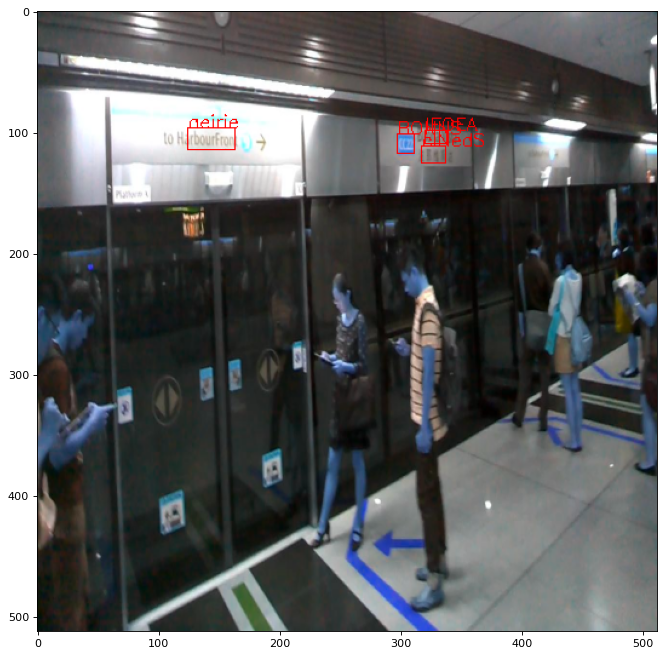

In [4]:
start_time = time.time()

pts,txt,im= Inference(train['JPG'][1])
for i in range(len(txt)):
        
        
        cv2.polylines(im,[pts[i]],isClosed=True,color=(255,0,0),thickness=1)
        cv2.putText(im,txt[i],(pts[i][0][0],pts[i][0][1]),cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 0, 0), 1)
      

from matplotlib.pyplot import figure

figure(figsize=(10, 15), dpi=80)
    
plt.imshow(im)
end_time = time.time()
print("Time Taken By Pipeline=" + str(end_time - start_time) + " seconds")

In [ ]:
start_time = time.time()
j=[]
for i in range (3):
    pts,txt,im= Inference(train['JPG'].iloc[i+10])
    
    for i in range(len(txt)):
        
        
        cv2.polylines(im,[pts[i]],isClosed=True,color=(255,0,0),thickness=1)
        cv2.putText(im,txt[i],(pts[i][0][0],pts[i][0][1]),cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 0, 0), 1)
      
    j.append(im)
from matplotlib.pyplot import figure
fig, ax = plt.subplots(1,3,figsize=(15,5))
for k in range(3):
                ax[k].imshow(j[k])             
            
plt.imshow(im)
